In [21]:
import bnpy
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns

FIG_SIZE = (15, 8)
plt.rcParams['figure.figsize'] = FIG_SIZE
# %qtconsole

# dataset_path = os.path.join('..', 'data')
# all_data = bnpy.data.XData.read_csv(os.path.join(dataset_path, 'anomaly0245.csv'))


# Prepare Data

Create training data and new batch data for simple test.

In [2]:
train_dataset = all_data.make_subset(example_id_list=list(range(100000,150000)))
new_batch = all_data.make_subset(example_id_list=list(range(150000, 200000)))

In [18]:
###############################################################################
# Generate time series with regime switching.
num_regime = 3
regime_noise = [0.1, 5, 1]
regime_loc = [10,5,0]
num_ts_samp = 5000  # number of data point
prop = [0.5, 0.3, 0.2]  # propotion of time in a regime

obs = []
cur_num = 0
while cur_num <= num_ts_samp:
    new_samp = np.random.poisson(100)
    reg_choice = np.random.randint(3)
    reg_obs = np.random.normal(regime_loc[reg_choice], regime_noise[reg_choice], new_samp)
    
    obs.append(reg_obs)
    cur_num += new_samp
    
obs = np.concatenate(obs)

train_dataset = bnpy.data.XData(obs.reshape(-1,1))
new_obs = np.random.normal(0, regime_noise[0], 100) + regime_loc[0]
new_batch = bnpy.data.XData(new_obs.reshape(-1,1))

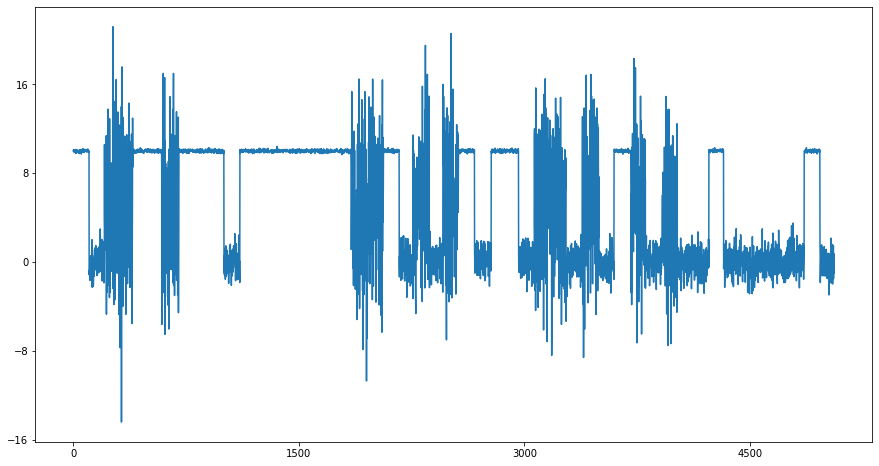

In [31]:
plt.plot(obs)
plt.show()

# Train model

Lots of hyper-parameters that can be tuned and changed to improve model learning.

In [20]:
###############################################################################
#
# *DiagGauss* observation model
# --------------------------------------------
#

gamma = 1.0
sF = 1.0
K = 10  # Initialize K component

trained_model, info_dict = bnpy.run(
    train_dataset, 'DPMixtureModel', 'DiagGauss', 'memoVB',
    output_path=f'/tmp/faithful/trymoves-K={K}-gamma={gamma}-lik=DiagGauss-ECovMat={sF}*eye-moves=none/',
    nLap=1000, nTask=1, nBatch=100, convergeThr=0.0001,
    gamma0=gamma, sF=sF, ECovMat='eye',
    moves='birth,merge,delete,shuffle',
    K=K, initname='randexamplesbydist', ts=True)

  --ts
Dataset Summary:
X Data
  total size: 5063 units
  batch size: 51 units
  num. batches: 100
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 3 
  beta = [ 1] 
  Expectations
  E[  mean[k]] = 
  [ 0]
  E[ covar[k]] = 
  [[1.]]
Initialization:
  initname = randexamplesbydist
  K = 10 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/faithful/trymoves-K=10-gamma=1.0-lik=DiagGauss-ECovMat=1.0*eye-moves=none/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
    0.010/1000 after      0 sec. |    184.3 MiB | K   10 | loss  3.04508636

DELETE @ lap 26.00: 0/1 accepted. Ndiff 0.00.
MERGE @ lap 26.00 : 0/2 accepted. Ndiff 0.00. 0 skipped.
   26.000/1000 after     64 sec. |    185.3 MiB | K    3 | loss  1.784251032e+00 | Ndiff    1.397 
BIRTH @ lap 27.000 : None attempted. 0 past failures. 0 too small. 3 too busy.
DELETE @ lap 27.00: 0/1 accepted. Ndiff 0.00.
MERGE @ lap 27.00 : 0/1 accepted. Ndiff 0.00. 0 skipped.
   27.000/1000 after     65 sec. |    185.3 MiB | K    3 | loss  1.783943844e+00 | Ndiff    0.764 
BIRTH @ lap 28.000 : None attempted. 0 past failures. 0 too small. 3 too busy.
DELETE @ lap 28.00: 0/1 accepted. Ndiff 0.00.
MERGE @ lap 28.00 : 0/2 accepted. Ndiff 0.00. 0 skipped.
   28.000/1000 after     66 sec. |    185.3 MiB | K    3 | loss  1.783833546e+00 | Ndiff    0.478 
MERGE @ lap 29.00: No promising candidates, so no attempts.
BIRTH @ lap 29.000 : None attempted. 0 past failures. 0 too small. 3 too busy.
DELETE @ lap 29.00: 0/1 accepted. Ndiff 0.00.
   29.000/1000 after     67 sec. |    185.3 MiB | K

# New Operations  

- Only done on replacing the batchSS.
- There are SS specific copy operations, find out and used them  
- [] Figure out calculation of propXSS which is needed for anomaly detection.

In [22]:
# Get the learned SS from model and info dict

S_k0 = copy.deepcopy(info_dict["SS"])  # This is the S_k0, sufficient statistics of the component of entire dataset
SSmemory = copy.deepcopy(info_dict["SSmemory"])  # Dictionary of SS for all batches

In [29]:
vars(trained_model.obsModel.Post)

{'K': 3,
 'D': 1,
 '_FieldDims': {'nu': 'K', 'kappa': 'K', 'm': ('K', 'D'), 'beta': ('K', 'D')},
 'doCollapseK1': False,
 'nu': array([2037.07130933, 1787.54577484, 1247.38291583]),
 'kappa': array([2034.07140933, 1784.54587484, 1244.38301583]),
 'm': array([[ 9.99914628],
        [-0.01563243],
        [ 4.98047486]]),
 'beta': array([[2.07404278e+01],
        [1.76358621e+03],
        [3.11622227e+04]])}

In [43]:
# Intuitively, this step calculates how well the current model explains new batch of data. 

LP = trained_model.calc_local_params(new_batch)  # Calculation of responsibility, needed for next step
SS_new = trained_model.get_global_suff_stats(new_batch, LP)  # Calculation of SS for new data

# Hopefully, this SS_new will/should be quite different from S_k0 if new_batch has anomaly.

In [54]:
vars(SSmemory[1]._Fields)

{'K': 3,
 'D': 1,
 'M': 1,
 '_FieldDims': {'N': 'K', 'x': ('K', 'D'), 'xx': ('K', 'D')},
 'doCollapseK1': False,
 'N': array([22.80018985, 17.71404142,  9.48576873]),
 'x': array([[250.72662456],
        [133.52856216],
        [ 10.93060219]]),
 'xx': array([[2757.30387835],
        [1313.62851178],
        [  20.36811851]])}

In [55]:
# Replace with Queue System
nBatch = len(SSmemory.keys())
SSmemory.pop(0)
for ii in range(1,nBatch):
    SSmemory[ii-1] = SSmemory.pop(ii)
SSmemory[nBatch-1] = SS_new

In [56]:
vars(SSmemory[0]._Fields)

{'K': 3,
 'D': 1,
 'M': 1,
 '_FieldDims': {'N': 'K', 'x': ('K', 'D'), 'xx': ('K', 'D')},
 'doCollapseK1': False,
 'N': array([27.39967102, 15.69088535,  6.90944363]),
 'x': array([[300.49371821],
        [ 89.88793014],
        [  4.8297884 ]]),
 'xx': array([[3295.84820355],
        [ 798.57937412],
        [   8.03651505]])}